# Evaluating triplet model

# Setting library path

In [3]:
import numpy as np
import pandas as pd
import os
import sys 

libpath = "lib"
sys.path.append(libpath)

# Configuration

In [1]:
DATASET_IMAGE_SIZE = (512, 512) # the image size in dataset loaded
EMBEDDING_INPUT_SHAPE = (128, 128, 3)
BATCH_SIZE = 32

# Importing packages

In [5]:
if "texture_dataset" in sys.modules:
    del sys.modules["texture_dataset"]

from texture_dataset import load_texture_dataset, load_texture_dataset_as_dataframe

if "dataset_viz" in sys.modules:
    del sys.modules["dataset_viz"]

from dataset_viz import plot_dataset_samples

if "split_dataset" in sys.modules:
    del sys.modules["split_dataset"]

from split_dataset import split_dataset_by_pixel, split_dataset_by_pixel_as_dataframe

if "imgaug_model" in sys.modules:
    del sys.modules["imgaug_model"]

from imgaug_model import build_augmentation_model

if "imgaug_viz" in sys.modules:
    del sys.modules["imgaug_viz"]

from imgaug_viz import plot_augmented_samples, plot_augmented_samples_for_one_image

if "supervised_model" in sys.modules:
    del sys.modules["supervised_model"]

from supervised_model import build_supervised_model, SupervisedModelDataGeneratorFromXy

if "knn_pred" in sys.modules:
    del sys.modules["knn_pred"]

from knn_pred import *

# Loading MBT dataset

In [7]:
from tensorflow import keras

dataset = keras.preprocessing.image_dataset_from_directory(
                "datasets_new/Multiband_Brodatz_Texture", 
                image_size = (128, 128), 
                #subset="training",
                #validation_split=0.2,
                batch_size = BATCH_SIZE,
                seed = 1234,
                shuffle=True
                )

Found 39424 files belonging to 154 classes.


In [8]:
n_classes = len(dataset.class_names)
#n_samples = len(dataset.file_paths)
n_samples = len(dataset) * BATCH_SIZE
n_batches = len(dataset)

print("n_classes = ", n_classes)
print("n_samples = ", n_samples)
print("n_batches = ", n_batches)

n_classes =  154
n_samples =  39424
n_batches =  1232


# Splitting dataset

In [9]:
dataset = dataset.shuffle(buffer_size = n_batches)

In [10]:
#
#    80% (training) + 20% (test)
#
# we keep 80% of the dataset as training
n_training_batches = np.int(0.8 * n_batches)
dataset_training = dataset.take(n_training_batches)

# we keep 10% of the dataset as testing
n_testing_batches = n_batches - n_training_batches
dataset_testing = dataset.skip(n_training_batches).take(n_testing_batches)

print("n_training_batches = ", n_training_batches)
print("n_testing_batches = ", n_testing_batches)

n_training_batches =  985
n_testing_batches =  247


In [11]:
for data, labels in dataset_training.take(1):
    print(data.shape)
    print(labels.shape)

(32, 128, 128, 3)
(32,)


In [127]:
accuracy_train, accuracy_test = knn_accuracy(X_train_, y_train, X_test_, y_test, k = 1)

print("accuracy_train = ", accuracy_train)
print("accuracy_test = ", accuracy_test)

accuracy_train =  1.0
accuracy_test =  0.18181818181818182


In [148]:
if "triplet_model" in sys.modules:
    del sys.modules["triplet_model"]

from triplet_model import *

In [237]:
if "embedding_simple" in sys.modules:
    del sys.modules["embedding_simple"]

from embedding_simple import build_simple_embedding_model

In [238]:
#EMBEDDING_INPUT_SHAPE = (128, 128, 3)
#EMBEDDING_OUTPUT_DIMS = 10

In [239]:
embedding_model = build_simple_embedding_model()
embedding_model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
global_max_pooling2d_11 (Glo (None, 32)                0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)              

In [151]:
test_generate_triplets()


Loading dataset from path: datasets/mbt ...
image size:  (512, 512)
Total 154 images are loaded.

Splitting dataset into training and testing dataset ...
size of training dataset : 154
size of testing dataset : 154
training dataset shape: (154, 256, 512, 3)
testing dataset shape: (154, 256, 512, 3)

Building augmentation model ...
input_size = (256, 512, 3)
output_size = (128, 128, 3)

(32, 128, 128, 3)
(32, 128, 128, 3)
(32, 128, 128, 3)

|a-p| =  267339.2
|a-n| =  268393.22


In [152]:
test_TripletLossLayer()

In [153]:
triplet_model = build_triplet_model(embedding_model = embedding_model)


Building contrastive model with triplet loss ...
inputs_shape =  (128, 128, 3)


In [154]:
X, y = load_mbt_dataset()
    
X_train, y_train, X_test, y_test = split_mbt_dataset(X, y, split = 0.5)
    
img_augmenter = build_augmentation_model()

train_generator = generate_triplets(img_augmenter = img_augmenter,
                                    batch_size = 32,
                                    X = X_train, 
                                    y = y_train)


Loading dataset from path: datasets/mbt ...
image size:  (512, 512)
Total 154 images are loaded.

Splitting dataset into training and testing dataset ...
size of training dataset : 154
size of testing dataset : 154
training dataset shape: (154, 256, 512, 3)
testing dataset shape: (154, 256, 512, 3)

Building augmentation model ...
input_size = (256, 512, 3)
output_size = (128, 128, 3)


In [159]:
triplet_history = triplet_model.fit(
                  train_generator, 
                  epochs = 100,
                  steps_per_epoch=10,
                  #validation_steps=1,
                  verbose=1
                 )

Epoch 1/100
10/10 [==============================] - 5s 440ms/step - loss: 0.0740
Epoch 2/100
10/10 [==============================] - 5s 459ms/step - loss: 0.0961
Epoch 3/100
10/10 [==============================] - 5s 490ms/step - loss: 0.0854
Epoch 4/100
10/10 [==============================] - 5s 471ms/step - loss: 0.0919
Epoch 5/100
10/10 [==============================] - 5s 485ms/step - loss: 0.0837
Epoch 6/100
10/10 [==============================] - 5s 486ms/step - loss: 0.0989
Epoch 7/100
10/10 [==============================] - 5s 527ms/step - loss: 0.0820
Epoch 8/100
10/10 [==============================] - 6s 575ms/step - loss: 0.0814
Epoch 9/100
10/10 [==============================] - 6s 626ms/step - loss: 0.0925
Epoch 10/100
10/10 [==============================] - 6s 590ms/step - loss: 0.0792
Epoch 11/100
10/10 [==============================] - 6s 583ms/step - loss: 0.0748
Epoch 12/100
10/10 [==============================] - 6s 619ms/step - loss: 0.0894
Epoch 13/100


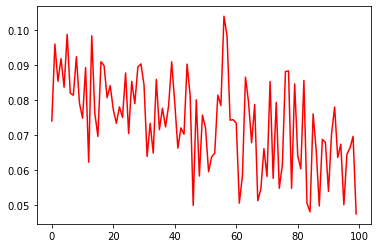

In [160]:
triplet_loss_hist = triplet_history.history["loss"]
plt.plot(triplet_loss_hist, color = "red")
plt.show()

In [172]:
img_augmenter = build_augmentation_model()

# train dataset
X_train_ = img_augmenter(X_train)

X_train_ = embedding_model.predict(X_train_)

print()
print("X_train_.shape = ", X_train_.shape)

num_of_samples = X_train_.shape[0]

print("num_of_samples = ", num_of_samples)

X_train_ = X_train_.reshape(num_of_samples, -1)

print("X_train_.shape = ", X_train_.shape)

# test dataset
#X_test_ = img_augmenter(X_test)
#X_test_ = embedding_model.predict(X_test_)

X_test_ = img_augmenter(X_train)
X_test_ = embedding_model.predict(X_test_)

print()
print("X_test_.shape = ", X_test_.shape)

num_of_samples = X_test_.shape[0]

print("num_of_samples = ", num_of_samples)

X_test_ = X_test_.reshape(num_of_samples, -1)

print("X_test_.shape = ", X_test_.shape)


Building augmentation model ...
input_size = (256, 512, 3)
output_size = (128, 128, 3)

X_train_.shape =  (154, 10)
num_of_samples =  154
X_train_.shape =  (154, 10)

X_test_.shape =  (154, 10)
num_of_samples =  154
X_test_.shape =  (154, 10)


In [173]:
accuracy_train, accuracy_test = knn_accuracy(X_train_, y_train, X_test_, y_test)

print("accuracy_train = ", accuracy_train)
print("accuracy_test = ", accuracy_test)

accuracy_train =  1.0
accuracy_test =  0.17532467532467533


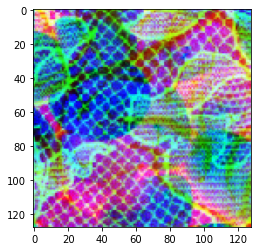

In [186]:
Xi = X_train[2] + 0.5

Xi_1 = img_augmenter(np.expand_dims(Xi, axis = 0))

Xi_1 = Xi_1[0]

plt.imshow(Xi_1, vmin = 0, vmax = 1.0)
plt.show()

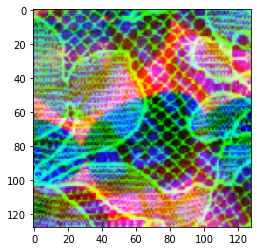

In [188]:
Xi_2 = img_augmenter(np.expand_dims(Xi, axis = 0))

Xi_2 = Xi_2[0]

plt.imshow(Xi_2, vmin = 0, vmax = 1.0)
plt.show()

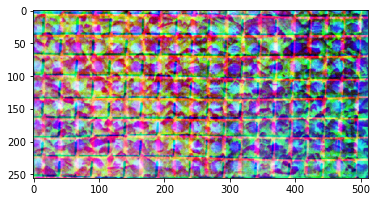

In [167]:
plt.imshow(X_test[0] + 0.5, vmin = 0, vmax = 1.0)
plt.show()

In [235]:
if "tsne_viz" in sys.modules:
    del sys.modules["tsne_viz"]

from tsne_viz import *

AttributeError: 'PathCollection' object has no property 'colour'

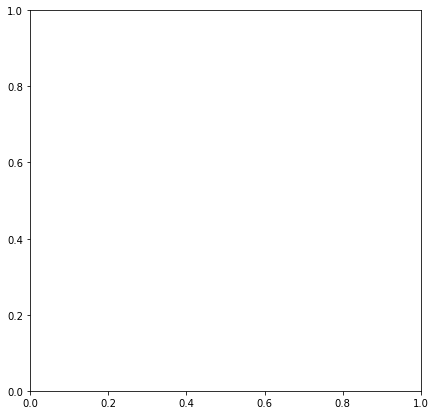

In [236]:
import random
indices = list(range(len(X_train)))
indices = np.random.choice(indices, 5, replace = False)

labels = y_train[indices]
features = X_train[indices]

#features, labels = sample_n_features(X, y, n, imgaug):
    
plot_tsne_proj(features, labels)